# Experiments

In this notebook we will collate and create miniature pipelines for collecting our final data. Finally, we will perform some data analysis.

# MNIST Experimentation

In this case we will be using the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database). There is something to be said about good performance on this task, but we should not expect too much: most of the data is heavily correlated with
one another. Barring pre-processing which orthogonalizes the data, there will be a lot of cross-talk.

## Setup

In [1]:
import sys
from pathlib import Path

# Go up one level from 'experiments/' to the project root
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from wirex.models.rate import GeneralHebbian, Hopfield  # noqa: E402

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.lax as lax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from einops import rearrange
from numpy.typing import NDArray
from randomdata.models import random_models
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm

# Cache for serializing MNIST, meaning that we don't have to download it all the time.
DATA_CACHE = "../.cache/mnist"
PIXEL_WIDTH = 28  # Height and width of the MNIST images
PIXEL_HEIGHT = 28

Here we will be doing some basic data processing, creating a pipeline between the MNIST dataset
using a `DataLoader` and randomly generated Hebbian associative memories.

In [3]:
def transform(data: torch.Tensor) -> NDArray:
    """Transform the MNIST data into a flat format.

    Args:
        data: `(28, 28)` image tensor representing MNIST data.

    Returns:
        Flattened `(28 * 28,)` `numpy.array`.
    """
    dataarr: NDArray[np.float32] = np.array(data, dtype=jnp.float32)
    # Flatten the tensors
    dataarr = rearrange(dataarr, "w h -> (w h)")
    # Binarize the data
    dataarr[dataarr > 0.0] = 1.0
    dataarr[dataarr == 0] = -1.0
    return dataarr


def generate_models(
    key: jax.Array, number_of_models: int, pattern_dim: int = PIXEL_HEIGHT * PIXEL_WIDTH
) -> list[GeneralHebbian]:
    """Randomly generate Hebbian associative memories using the `wirex` framework.

    Args:
        key: A `jr.PRNGKey`.
        number_of_models: Non-negative integer number of models to generate.
        pattern_dim: Default `PIXEL_WIDTH*PIXEL_HEIGHT`. Dimension of the patterns to store in the models.

    Returns:
        List of models of length `number_of_models`.
    """
    return random_models(key=key, num_models=number_of_models, pattern_dim=pattern_dim)


def mnist_data(train: bool, batch_size: int):
    mnist = MNIST(DATA_CACHE, train=train, transform=transform, download=True)
    mnist_data_loader = DataLoader(mnist, batch_size=batch_size, shuffle=True)
    mnist_it = iter(mnist_data_loader)
    data, _ = next(mnist_it)
    return jnp.array(data)


def display_pair(img1, img2, titles=["", ""]):
    images = [jnp.array(img).reshape(28, 28) for img in [img1, img2]]
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.set_title(titles[i])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()


def display_recall(
    img1,
    img2,
    img3,
    titles=[
        "",
        "",
        "",
    ],
):
    images = [
        jnp.array(img).reshape(28, 28)
        for img in [
            img1,
            img2,
            img3,
        ]
    ]
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.set_title(titles[i])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()

def show_im(im: jax.Array, title: str = "") -> None:
    im = im * 255.0
    im = rearrange(im, "(w h) -> w h", w=PIXEL_WIDTH, h=PIXEL_HEIGHT)
    plt.imshow(im)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])

****************************************************************************
* hwloc 2.0.3 received invalid information from the operating system.
*
* Failed with: intersection without inclusion
* while inserting Group0 (P#16 cpuset 0x00000f00) at L1d (P#16 cpuset 0x00000104)
* coming from: linux:sysfs:cluster
*
* The following FAQ entry in the hwloc documentation may help:
*   What should I do when hwloc reports "operating system" warnings?
* Otherwise please report this error message to the hwloc user's mailing list,
* along with the files generated by the hwloc-gather-topology script.
* 
* hwloc will now ignore this invalid topology information and continue.
****************************************************************************
W0217 16:27:40.673354   21137 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0217 16:27:40.676698   21022 cuda_executor.cc:1802] GPU intercon

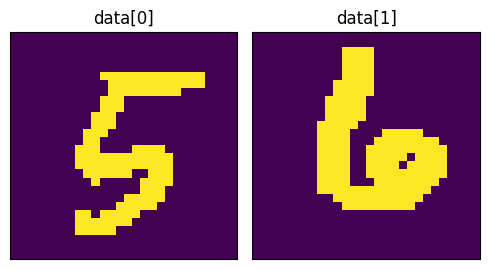

In [4]:
data = mnist_data(True, 100)

display_pair(data[0], data[1], titles=["data[0]", "data[1]"])

## Running the Experiment

Here we will be running the full MNIST experiment.

### Hopfield Networks

The goal here is to see: what is the best performance of randomly initialized Hebbian associative networks?
For comparison, we will use a simple and classic Hebbian associative memory, the Hopfield network.

In [5]:
min_entries = 1
max_entries = 200 # number of patterns to store in the networks
data = mnist_data(True, max_entries)

Here we can see the basic structure of the task. We are going to store some patterns in the Hebbian
associative network, and then query it to see the results.

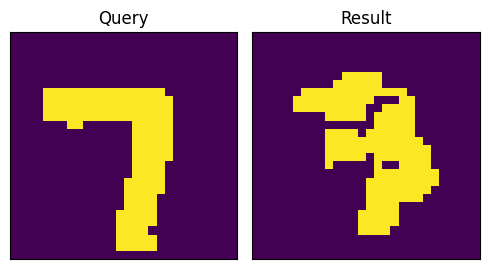

In [6]:
Xi = data[:3]
W = Xi.T @ Xi 
hopfield = Hopfield(W)
query = data[0]
result = hopfield(query)
display_pair(query, result, ["Query", "Result"])

The metric that we are going to use to measure success is simply *cosine similarity* between 
the query and the result.

In [7]:
def cosine_similarity(x: jax.Array, y: jax.Array) -> jax.Array:
    """Return the cosine similarity between two arrays."""

    x_norm = jnp.linalg.norm(x)
    x_norm = x_norm if x_norm != 0.0 else 0.1e-8
    y_norm = jnp.linalg.norm(y)
    y_norm = y_norm if y_norm != 0.0 else 0.1e-8

    return float(x.dot(y) / (x_norm * y_norm))


cosine_similarity(query, result)

0.7831632494926453

Now that we know that the model can perform well on a single instance, and we have a measure of the similarity between
the query and the result, we will now test the relation between the similarity of query-result pairs as a function 
of the number of patterns stored in the network. We call this relationship the *scaling* relationship.

In [8]:
experimental_results = {
    "query": [], # Storing the query
    "result": [], # Storing the result
    "cosine_similarity": [], # Cosine similarity between the query and the result
    "trial": [], # The trial number
}

for i in tqdm(range(min_entries, max_entries+1)):
    Xi = data[:i]
    weights = Xi.T @ Xi
    hopfield = Hopfield(W)
    trial = i+1 
    for j in range(i):
        query = data[j]
        result = hopfield(query)
        sim = cosine_similarity(query, result)
        experimental_results["query"].append(np.array(query))
        experimental_results["result"].append(np.array(result))
        experimental_results["cosine_similarity"].append(sim)
        experimental_results["trial"].append(trial)

100%|██████████| 200/200 [01:36<00:00,  2.08it/s]


In [9]:
hopfield_df = pd.DataFrame(experimental_results)
hopfield_df.head()

,query,result,cosine_similarity,trial
0,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",0.783163,2
1,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",0.783163,3
2,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",0.775510,3
3,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",0.783163,4
4,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",0.775510,4


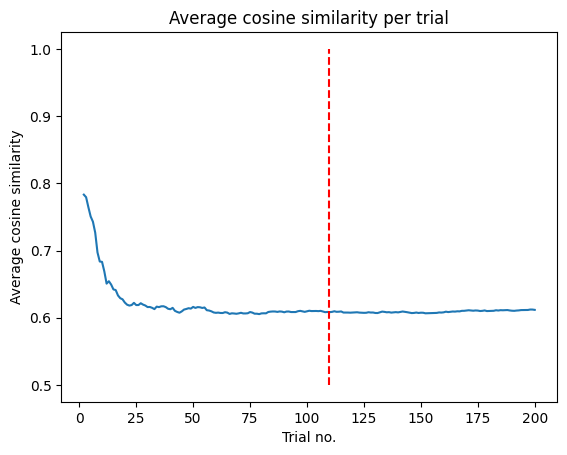

In [10]:
num_trials = hopfield_df.trial.max()
trials = []
for i in range(num_trials):
    mean_per_trial = hopfield_df[hopfield_df.trial == i].cosine_similarity.mean()
    trials.append(mean_per_trial)

plt.plot(trials[:300])
plt.xlabel("Trial no.")
plt.ylabel("Average cosine similarity")
plt.title("Average cosine similarity per trial")
plt.vlines(.14 * PIXEL_HEIGHT*PIXEL_WIDTH, ymin=.5, ymax=1, linestyle='--', color="red")
plt.show()

The red line in the above figure depicts the predicted theoretical limit of the capacity of Hopfield networks,
namely $14\%$ of the dimension of the weights. Unfortunately, MNIST each element in the MNIST set is highly correlated with itself (with our naive pre-processing). This means that performance significantly degrades even after the first couple of patterns. Afterwards, we get a flat result of 70% cosine similarity, which is practically useless.

## Hebbian associative networks

Now that we have the basic structure of the experiment, we'll proceed with working with Hebbian associative networks using the `wirex` module.
Here, we're only going to compare 10 models on the task, and surely not to the same limit.

In [11]:
max_entries = 100
key = jr.PRNGKey(111)
number_of_models = 30
models = generate_models(key=key, number_of_models=number_of_models)

experimental_results = {
    "query": [], # Storing the query
    "result": [], # Storing the result
    "cosine_similarity": [], # Cosine similarity between the query and the result
    "coefficients": [], # The model coefficients, largely reproduces the same information as `model_number`.`
    "model_number": [], # Which model
    "trial": [], # The trial number
}

for i in tqdm(range(max_entries)):
    idx = i + 1
    Xi = data[:idx]
    fitted_models = [model.fit(Xi) for model in models]
    for model_number, fitted_model in enumerate(fitted_models):
        for j in range(idx):
            query = data[j]
            result = fitted_model(query)
            trial = idx
            coeffs = fitted_model.coefficients.tolist()
            sim = cosine_similarity(query, result)
            experimental_results["query"].append(query)
            experimental_results["result"].append(result)
            experimental_results["cosine_similarity"].append(sim)
            experimental_results["coefficients"].append(coeffs)
            experimental_results["model_number"].append(model_number)
            experimental_results["trial"].append(trial)

100%|██████████| 100/100 [05:44<00:00,  3.45s/it]


In [12]:
han_df = pd.DataFrame(experimental_results)
han_df.head()

,query,result,cosine_similarity,coefficients,model_number,trial
0,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",0.642857,"[0.3504805564880371, 0.8339847326278687, 0.220...",0,1
1,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",-0.642857,"[0.4170488119125366, 0.641210675239563, 0.9034...",1,1
2,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",-0.642857,"[0.11517989635467529, 0.3415639400482178, 0.57...",2,1
3,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....",1.000000,"[0.8110381364822388, 0.2368924617767334, 0.803...",3,1
4,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1....","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",-0.642857,"[0.006376862525939941, 0.8012230396270752, 0.7...",4,1


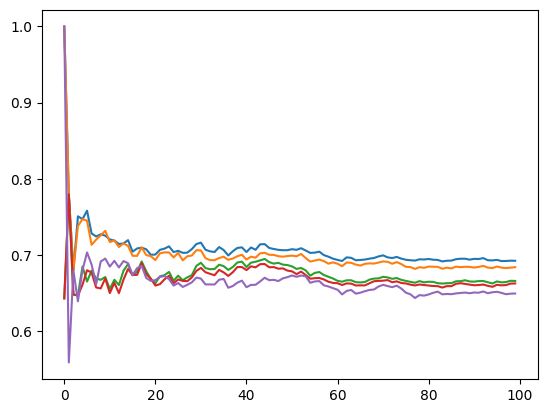

In [20]:
num_trials = han_df.trial.max()

avg_results = []
for i in range(number_of_models):
    i_results = []
    for j in range(num_trials):
        avg_result = han_df[(han_df.model_number == i) & (han_df.trial == j+1)].cosine_similarity.mean()
        avg_result = np.abs(avg_result)
        i_results.append(avg_result)
    avg_results.append(i_results)

# for i, results in enumerate(avg_results):
#     plt.plot(results, label=f"Model {i}")
# plt.legend()
total_avg = sorted([(i, np.mean(res)) for i, res in enumerate(avg_results)], key=lambda x: x[1], reverse=True)
total_avg[:5]
top_5_results = [avg_results[10], avg_results[20], avg_results[19], avg_results[6], avg_results[11]]

for results in top_5_results:
    plt.plot(results)
plt.show()

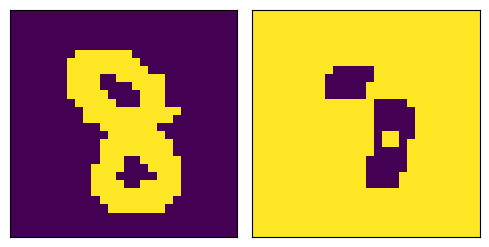

-0.6173469424247742

In [35]:
Xi = data[:2]
fitted_model = models[10].fit(Xi)
query = data[3]
result = fitted_model(query)
display_pair(query, result)

cosine_similarity(query, result)

As we can see, performance is highly similar to the Hopfield network (even missing the theoretical capacity for uncorrelated, random patterns in the same way). Now, we can get the results for the random data.